# Linear B-cell Epitope Prediction

#### Author : Bhageeradh Paleti, Dept of EPS, Aston University, Birmingham, United Kingdom

## Abstract
***
Identifying B-cell epitopes is crucial in developing vaccines and diagnostic tests against infectious diseases, allergies, and some cancers. However, the experimental discovery of epitopes can be time-consuming and resource-intensive. This coursework involves developing an efficient data mining pipeline to predict B-cell epitopes for Alphavirus, a genus of mosquito-borne viruses [1-3]. We will make use of the different levels of datasets segregated by the density of the Alphavirus and its distant relatives. We are following a typical Data mining workflow like CRISP-DM with different stages of development, including EDA, Pre-processing, Feature Engineering and Modelling. After testing different classification models, we achieved good results (0.91 ROC-AUC Score) for the LogisticRegression models. The model was almost robust to the class imbalance in the Level-2 dataset, especially with the class of interest being the minority class. However, the model performing well with the Level-2 dataset suggests that the models are not entirely robust towards higher-level datasets with a more distant relative of the virus.
<br>
## Introduction
***

Detection of Linear B-cell epitopes, short protein fragments, is an essential early step in developing vaccines, diagnostic tests [1-3]. However, the experimental discovery of epitopes can be time-consuming and resource-intensive. To address this challenge, computational methods have been developed to identify and prioritise potential epitopes for further characterisation in the lab. In this coursework, we will explore epitope data and attempt to predict epitopes for Alphavirus, a genus of mosquito-borne. We will be working with datasets compiled by the Aston University team, to develop an efficient data mining pipeline to predict new epitopes in viruses from the Alphavirus genus. Along with predicting the epitopes, we will also compare the models and analyse the effect of the level and characteristics of the dataset used for the final model.
<br>
### Data Overview :

The data used in this coursework is the epitope dataset to predict Alphavirus, retrieved and consolidated from online databases IEDB, Genbank and UniProtKB by Dr Felipe Campelo and Ms Abi Sowriraghavan as part of the CS4850 Data Mining module. The datasets were available on the blackboard as .csv, .pkl and .rds files for Python and R, respectively.

The research [1-3] shows a potential trade-off between a smaller volume with data similar to the target and a larger dataset with different viruses. Therefore, five datasets with increasing volumes with more data from distant relatives of the Alphavirus genus are used to explore this.

<b>Data Structure :

All the datasets have 1293 attributes and one target class. The general structure of the data is as follows.
-	Information Columns: Of the 1293 attributes, 13 columns with the prefix’ Info_’ represents general information about the observations and are usually not useful for predictions.
-	Feature Columns: There are 1280 attributes labelled with the prefix’ feat_’ extracted using a state-of-the-art feature embedder for protein data, ESM-1b [4].
-	Target/Class Columns: 1 Class column labelled ‘Class’.

Even though the information columns are not helpful for modelling or prediction, one of the Information columns, “Info_cluster”, seems to categorize the observations. So this information is used to split the data so that the clusters are spread-out evenly across train, test and validation sets.


## Packages
***
The followings are the packages and libraries used throughout the coursework.
-	Pandas and Numpy: data analysis and manipulation tools
-	Scikit-learn: machine learning library
-	Imblearn: Over-sampling and under-sampling data
-	Matplotlib and Seaborn: for plotting graphs
-	MRMR: “minimum Redundancy - Maximum Relevance” is a feature selection algorithm


In [157]:
import math
import random
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from textwrap import wrap

import sklearn.metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from tabulate import tabulate

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
!pip install mrmr_selection
from mrmr import mrmr_classif

!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

!pip install Boruta
from boruta import BorutaPy


!pip install skfeature

!pip install xgboost
from xgboost import XGBClassifier

#### Loading the data

We will start with the level 2 dataset to build a base model and then advance to modelling and testing with the other datasets.

There are 4946 observations with 1294 attributes in the Level-2 dataset (L2).


In [3]:
l2_data = pd.read_csv('../Data/df_training_level2.csv')
# level_3_data = pd.read_pickle('C:\Docs & Resources\Aston\Data Mining\Coursework\Data\df_training_level3.pkl')
# level_5_data = pd.read_pickle('C:\Docs & Resources\Aston\Data Mining\Coursework\Data\df_training_level5.pkl')
print('Level 2 Dataset loaded, Shape : ', l2_data.shape)

Level 2 Dataset loaded, Shape :  (4946, 1294)


In [4]:
l2_data.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,BAA01867.1:2,1678143,BAA01867.1,262,E,10449466,14543,9606,1,1,...,-0.070886,-0.017200,-0.117530,-0.007250,-1.071874,-0.519040,-0.308719,-0.281276,-0.256712,0.405690
1,BAA01867.1:2,1678143,BAA01867.1,263,T,10449466,14543,9606,1,1,...,0.220630,-0.210780,-0.021335,0.323588,-0.736865,-0.343829,-0.507386,-0.020137,-0.166644,0.751316
2,BAA01867.1:2,1678143,BAA01867.1,264,S,10449466,14543,9606,1,1,...,0.107350,-0.059491,-0.167905,0.257423,-0.930690,-0.271957,-0.133815,0.044392,-0.299376,0.461547
3,BAA01867.1:2,1678143,BAA01867.1,265,G,10449466,14543,9606,1,1,...,0.253621,-0.267090,-0.109026,0.091992,-0.813677,-0.187964,-0.142268,0.091157,-0.436975,0.369129
4,BAA01867.1:2,1678143,BAA01867.1,266,V,10449466,14543,9606,1,1,...,0.027382,0.018629,-0.157104,0.305302,-1.121274,-0.048636,-0.246171,0.147852,-0.299121,0.225209


##### Features split

Since there are different types of columns in the dataset, let’s identify and keep a note of them.

<b>Information Columns:</b> Columns with prefix - ‘<b>Info_</b>’
<b>Feature Columns:</b> Columns with prefix - ‘<b>feat_</b>’
<b>Target / Label:</b> Column with name ‘<b>Class</b>’


In [5]:
# All the Attributes split into respective categories
feat_columns = l2_data.filter(like='feat_', axis=1).columns
target_class = 'Class'

Typically, EDA is the first stage after loading the data. We will also perform EDA first, but before starting with EDA, we want to split data into three parts and use them in different stages of the data mining lifecycle. We will discuss this in detail in the EDA section. So, for now, to avoid unnecessary noise and inconvenience during splitting or other EDA, we will check and remove the null values and duplicates from the dataset.

In [6]:
print('Null Observations/Records : ', len(l2_data[l2_data[feat_columns].isna().all(axis=1)]))
print('Null Features : ', np.count_nonzero(l2_data[feat_columns].isna().all(axis=0) == True))

Null Observations/Records :  521
Null Features :  0


##### Removing null records and duplicates from the Dataset

In [7]:
def pp_clean(d):
    before = d.shape[0]
    d = d.drop_duplicates()
    d = d.dropna()

    print('Duplicated Records (Features): ', d.duplicated(subset=feat_columns).sum())
    duplicates = d.duplicated(subset=feat_columns, keep='first')
    duplicate_indices = d.index[duplicates].tolist()
    d = d.drop(duplicate_indices)

    d = d.reset_index(drop=True)
    print('Dropped Null and duplicate records : ', before - d.shape[0])
    return d


def pp_clean_old(d):
    before = d.shape[0]
    d = d.drop_duplicates()
    d = d.dropna()
    d = d.reset_index(drop=True)
    print('Dropped Null and duplicate records : ', before - d.shape[0])
    return d


l2_data = pp_clean(l2_data)
print('Size after basic cleaning = ', l2_data.shape)

Duplicated Records (Features):  0
Dropped Null and duplicate records :  521
Size after basic cleaning =  (4425, 1294)


After removing the null and duplicate entries from the data, we have 4425 records. Let’s get started with EDA.

## Exploratory Data Analysis
***

Exploratory Data Analysis (EDA) is the process of examining and understanding the data. Being an essential stage of the data mining process, Exploratory Data Analysis (EDA) assists in identifying data issues like the detection of outliers, missing values, and even potential biases present in the data.


We planned to split the data into three sets and use them for performing EDA (EDA set), Modelling (i.e., Train/Model set) and Testing(Test set). We are using a separate split for EDA and modelling, assuming that the EDA set represents the entire dataset (as a proxy). So it is important to make sure that the data is appropriately split. First, let’s look at the target class distribution.

##### Data distribution by class label

In [8]:
def plot_distribution(dfs, titles=[], plot='pie', feature='Class', scale=6):

    plt.figure(figsize=(scale * len(dfs), scale))
    i = 1
    for df in dfs:
        counts = df[feature].value_counts()
        plt.subplot(1, len(dfs), i)
        colors = ['blue', 'red']

        # plt.figure(figsize=(7, 7))
        # plt.figure(figsize=(12, 6))
        # plt.subplot(1, 2, 1)

        title = ''
        if len(titles) > 0:
            title = titles[i-1]

        if plot == 'pie':
            # Pie Plot
            plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
            plt.title('Class Distribution : ' + title)
            # plt.show()

        if plot == 'bar':
            # Bar plot
            # plt.subplot(1, 2, 2)
            if len(counts.index) == 2:
                plt.bar(list(map(str, counts.index)), counts.values, color=colors)
            else:
                plt.bar(list(map(str, counts.index)), counts.values)

            plt.xticks(list(map(str, counts.index)))
            plt.ylabel('Number of Samples')
            plt.title('Class Distribution : ' + title)

        i += 1
    # plt.subplots_adjust(wspace=0.5)
    plt.show()

In [9]:
def print_distribution(df, text=''):
    p = len(df[df.Class == 1])
    n = len(df[df.Class == -1])
    if len(text) > 0:
        print('For', text , ' : ')
    print("Total Observations : ", len(df))
    print("         Positives : ", p, " ", round(p * 100 /len(df), 2), "%")
    print("         Negatives : ", n, " ", round(n * 100 /len(df), 2), "%")

Total Observations :  4425
         Positives :  1062   24.0 %
         Negatives :  3363   76.0 %


<AxesSubplot:xlabel='Class', ylabel='count'>

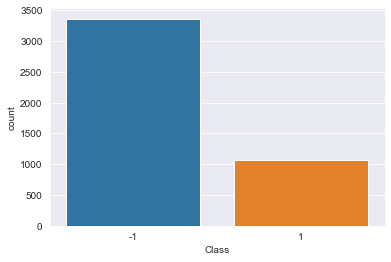

In [10]:
print_distribution(l2_data)
sns.countplot(l2_data.Class)

As we can see in the above graph, 76% of the data is of negative observations (Class = -1), and 24% are positives (1). So, we already have a less population of positive entries. If we split entirely at random, this imbalance might get worse. This is the first thing we have to take into account while performing a split.

On top of this, it was also mentioned with the data that it consists of an Information column (‘Info_cluster’), that categorizes the data and should be considered while splitting. So when we perform splitting, we have to make sure that these clusters are spread across all splits.

<AxesSubplot:xlabel='Info_cluster', ylabel='count'>

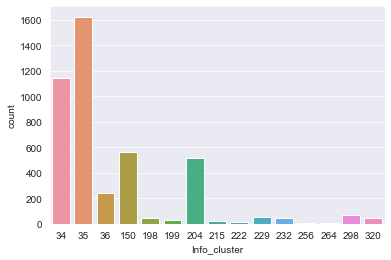

In [11]:
sns.countplot(l2_data.Info_cluster)

The population in the clusters is also not even. So, if we do not consider them while splitting, all records of a type may end up in one split. For instance, if any record in the data belongs to 3 categories A, B, C. Then, if the data is split incorrectly and, say, the train set has both A and B but not C. The model built on this type of data will perform poorly in predicting the data that belongs to C. Similarly, if a type of record is missing in the test set, it will not be validated during the testing phase, which may lead to unexpected behaviours.

On cross-examination with the target class, a few clusters are composed of both positive and negative values. Therefore, to ensure that the data is evenly distributed even in terms of the target class, we will create a new temporary target class (“Info_bins”) as a combination of “Info_cluster” and “Class”. Then, we use StratifiedKFold to split the data into 10 folds (saved as Info_fold, valued 1 - 10). Each fold will have a similar distribution to the original dataset (or, in this case, the EDA set).

##### Helper functions to split data into Train, Model and Test datasets~

In [12]:
def create_bins(a, b):
    return str(a) + '_' +  str(b)

def apply_kfolds(df):
    df.Class = df.Class.astype('category')
    df['Info_bins'] = df['Info_cluster'].astype(str) + '_' + df['Class'].astype(str)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)
    for n, (train_i, test_i) in enumerate(skf.split(df, df.Info_bins)):
        df.loc[test_i, 'Info_fold'] = int(n) + 1
    return df

def get_split_data_by_fold(df, ratio, exclude_cols=True):
    # folds = [i for i in range(1,11)]
    # random.shuffle(folds)

    folds = [8, 10, 7, 5, 4, 2, 9, 1, 3, 6]

    limits = [0, *np.cumsum(ratio)]
    split_indices = []
    for i in range(len(limits)-1):
        split_indices.append(folds[limits[i]:limits[i+1]])

    print('Split folds: ')
    for splits in split_indices:
        print(splits)

    drop_cols = df.filter(like='Info_', axis=1).columns
    if not exclude_cols:
        drop_cols = []

    data_splits = []

    for splits in split_indices:
        x = df[df.Info_fold.isin(splits)].drop(columns=drop_cols)
        data_splits.append(x)
    return data_splits

##### Splitting Data :
Based on the desired ratio for the splits, the data is separated with the help of the obtained folds. For example, we will split the data with 30% for EDA, 60% for Training (Modelling) and 10% for testing, i.e., 3, 6, 1. To maintain reproducibility, we took a shuffled list of 10 numbers and then picked splits based on the provided ratio. So, the first 3 folds combine together to form the EDA set, the next 6 folds merge the train set and the remaining 1 fold as the test set.

In [13]:
l2_kf = apply_kfolds(l2_data)
eda_l2, model_l2, test_l2 = get_split_data_by_fold(l2_kf, (3,6,1))

Split folds: 
[8, 10, 7]
[5, 4, 2, 9, 1, 3]
[6]


##### Checking data distribution after split into train, model and test sets

This is the distribution (77:23) of the target class across all three data-splits.

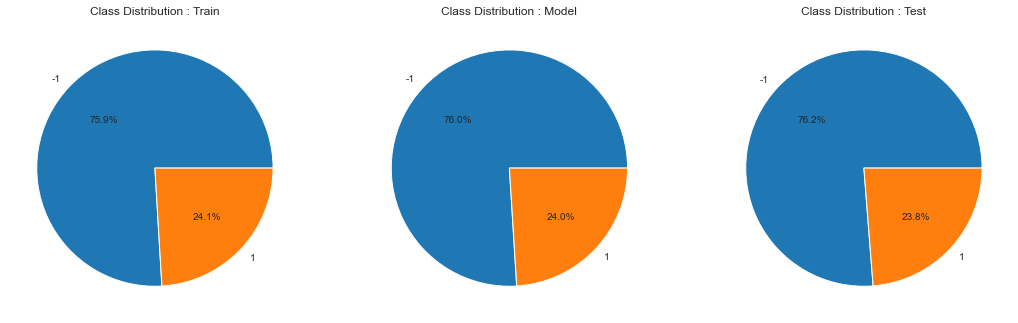

In [14]:
plot_distribution(dfs=[eda_l2, model_l2, test_l2], titles=['Train', 'Model', 'Test'])

As we are now done with splitting, we will begin the EDA process and use the EDA split for this phase.

#### Checking for Data types and Inconsistencies
A common first step of EDA is understanding the data types and checking for any value inconsistencies. As the data have 1280 features/attributes, it isn’t easy to manually check the data types and values. But, from the below result, we can see that all the feature attributes are of the same data type – float.

Since any information about the attributes is not available or relevant, we cannot determine if there are any inconsistencies in the range or scale of the data. For example, an attribute “Age” cannot be negative or zero.

In [15]:
eda_l2[feat_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 7 to 4424
Columns: 1280 entries, feat_esm1b_0 to feat_esm1b_1279
dtypes: float64(1280)
memory usage: 13.0 MB


In [16]:
print('Data types of the features : ')
print(set(eda_l2[feat_columns].dtypes))

Data types of the features : 
{dtype('float64')}


In [17]:
eda_l2[target_class].dtypes

CategoricalDtype(categories=[-1, 1], ordered=False)

#### Checking for Duplicates or Missing Values

Unrecorded values for an attribute or issues while data collection or consolidation are potentially missing values. Since the data is numeric, we don’t have to check different representations of missing values as strings (like “NA”, “NAN”, “N/A”, “UNKNOWN”).

The L2 dataset had few any null entries or duplicates. But, we have removed them before splitting the data. So, we don’t have to take any measures to treat missing values. But, if the higher-level datasets have missing values, we should either drop the attributes with significant missing values, remove the observations with missing values, or impute the missing values using a strategy like Hot-deck substitution.


In [18]:
def eda_check_duplicates(d):
    # print('***********************************')
    print("Duplicates in the dataset : ", d.duplicated().sum())

In [19]:
eda_check_duplicates(eda_l2)

Duplicates in the dataset :  0


#### Checking for Outliers
Outliers are data points that deviate significantly from other observations, which can be due to measurement errors, experimental errors, or natural variability in the data. We can usually find outliers using graphical methods, but it is not a feasible solution for high-dimensional data. So instead, we can use approaches like Isolation forests to identify potential outliers.

##### Outliers detection with Isolation Forests

In [20]:
def eda_outliers(df):
    isf = IsolationForest(contamination='auto', max_samples='auto', random_state=42)
    isf.fit(df[feat_columns])
    x = isf.predict(df[feat_columns])
    o2 = np.count_nonzero(x == -1)
    print('Potential outliers in the dataset detected by Isolation Forest : ', o2, ' (', round(o2/len(df), 2), '%)')
    return o2

o2 = eda_outliers(eda_l2)

Potential outliers in the dataset detected by Isolation Forest :  68  ( 0.05 %)


Since only a small percentage of outliers are present in the level-2 dataset, we can just remove them from the dataset during the pre-processing phase.

#### Checking Scale
Checking for scale during the EDA phase is an important step in understanding the data. One way to do this is by examining the minimum and maximum values of each feature in the dataset. If the ranges of the features vary widely, it could indicate that the data has not been normalized or standardized.

In [21]:
def eda_scale_graph(df, title='', size = (10, 5)):
    i = 1
    plt.figure(figsize=size)
    ranges = df[feat_columns].describe().loc[['min', 'max']]
    plt.plot(np.arange(0, len(ranges.loc['min'])),ranges.loc['min'], label = "Min Values")
    plt.plot(np.arange(0, len(ranges.loc['max'])),ranges.loc['max'], label = "Max Values")
    plt.xlabel('Attributes')
    plt.legend()
    plt.title("\n".join(wrap('Plot for checking scale ' + title, 50)), pad=20, fontsize=14)
    plt.show()

As we can see from the below graph, a few attributes differ in scale by a large margin, while others are just slightly different. To handle this, we can apply a Minmax scaler (Normalization) to transform the attributes to a common scale, i.e., 0-1.

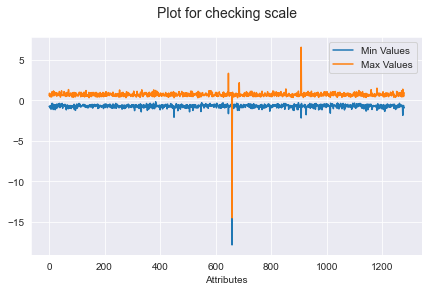

In [22]:
eda_scale_graph(eda_l2, size=(7, 4))

An alternate plot view the scales of attributes

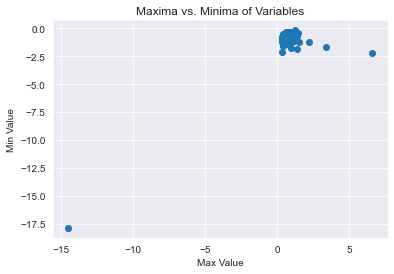

In [23]:
max_vals = eda_l2.max()
min_vals = eda_l2.min()

plt.scatter(x=max_vals, y=min_vals)
plt.xlabel('Max Value')
plt.ylabel('Min Value')
plt.title('Maxima vs. Minima of Variables')
plt.show()

#### Checking Class Distribution(Imbalance)
Class imbalance is a challenge in classification problems where the distribution of the target class is biased. Class imbalance can lead to biased or inaccurate models, as the model predicts the majority class more frequently than the minority class. This can be especially problematic when the minority class is the class of interest. Our class of interest is negative values and is the minority class in the dataset. So, this has to be appropriately addressed.

<AxesSubplot:xlabel='Class', ylabel='count'>

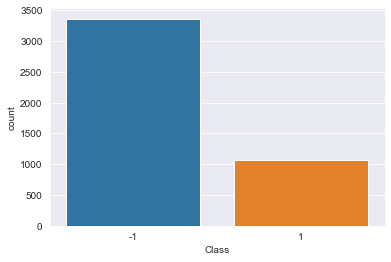

In [24]:
sns.countplot(l2_data.Class)

Strategies we can use to deal with class imbalance are:
1. Resampling: Either under-sampling the majority class or over-sampling the minority class
2. Algorithmic: By introducing class weights to the learning algorithm

## Data Pre-processing
***

Data pre-processing is the process of cleaning, transforming, and preparing raw data for analysis. Based on the understanding and findings from the initial EDA process, we have to perform the following steps during the Pre-processing stage :
1.	Since no missing values or duplicates to handle, we can skip countermeasures for them.
2.	A small percentage (0.05%) of outliers were present in the data. So we will remove the outliers from the dataset.
3.	As few features are on a different scale, we will use MinMaxScaler and transform the data.
4.	Earlier, we observed an imbalanced class distribution. To fix it, we will apply SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class by creating synthetic samples or under-sample the minority class.

To streamline the process, we will first create the required custom Transformers for the Pipeline, addressing each of the decided pre-processing measures/steps. They are as follows -

#### For Data Cleaning
Basic cleaning operations - removing nulls and duplicates
In order to avoid removing any records from the test or validation (holdout sets), we are configuring it to replace the null values of the test set with the mean value.

In [162]:
class DataCleaning(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.mode = 'Train'
        self.mean = None

    def fit(self, df, y=None):
        print('Training : ===========================================')
        print('')
        self.mean = df[feat_columns].mean()
        self.mode = 'Train'
        return self

    def transform(self, df):
        if self.mode == 'Train':
            prev = df.shape[0]
            df = df.dropna()
            df = df.drop_duplicates()
            print(self.mode, ': Dropped Nulls: ', prev - len(df))
            df, c = self.drop_duplicates(df)
            print(self.mode, ': Dropped duplicates: ', c)
        else:
            if max(df.isna().sum()) > 0:
                df[self.features].fillna(self.mean, inplace=True)

        print(self.mode, ': Data Cleaning Completed')
        self.mode = 'Test'

        return df

    def drop_duplicates(self, df):
        duplicates = df.duplicated(subset=self.features, keep='first')
        duplicate_indices = df.index[duplicates].tolist()
        df = df.drop(duplicate_indices)
        # df.reset_index
        return df, len(duplicate_indices)

#### For Outliers
Using Isolation forest to identify and remove outliers from the data (only for training data)

In [26]:
class Outliers(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.outliers = []
        self.outlier_count = 0
        self.mode = 'Train'

    def fit(self, df, y=None):
        self.mode = 'Train'

        out_model = IsolationForest(contamination='auto', max_samples='auto', random_state=42, max_features=int(math.sqrt(len(df.columns))))

        out_model.fit(df[self.features])
        x = out_model.predict(df[self.features])

        self.outliers = x == -1
        self.outlier_count = np.count_nonzero(x == -1)

        print(self.mode, ': Potential outliers: ', self.outlier_count, ' (', round(self.outlier_count/len(df), 2), '%)')

        return self

    def transform(self, df):
        if self.mode == 'Train':
            print(self.mode, ': Cleaning outliers (', self.outlier_count,') Completed')
            self.mode = 'Test'
            return df[~self.outliers]

        return df

#### For Scaling/Data Transformation
We will go with MinMaxScaler to normalize the data. Then, while handling the test data, we will transform it with the scaler that was fit the corresponding train data.

In [27]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler, features):
        self.scaler = scaler
        self.features = features
        self.mode = 'Train'

    def fit(self, df, y=None):
        self.mode = 'Train'
        self.scaler.fit(df[self.features])
        print(self.mode, ': Fitting scaler')
        return self

    def transform(self, df):
        eda_scale_graph(df[self.features], size=(4,2), title='(Before Scaling)')
        df[self.features] = self.scaler.transform(df[self.features])
        print(self.mode, ': Transforming Data (Scaling) Completed')
        self.mode = 'Test'
        eda_scale_graph(df[self.features], size=(4,2), title='(After Scaling)')
        return df

#### For Data (re) Balancing
We have implemented the under-sampling and over-sampling (SMOTE) approaches. So, we can build 2 different pipelines, i.e., one with under-sampling and the other with over-sampling

We use sampling strategy ‘1’ to generate synthetic samples till the minority class is equal to 100% of the majority class.

In [28]:
class Balancer(BaseEstimator, TransformerMixin):
    def __init__(self, type, features):
        self.features = features
        self.type = type
        self.sampler = None
        self.mode = 'Train'

    def fit(self, df, y=None):
        self.mode = 'Train'

        if self.type == 'US':
            self.sampler = RandomUnderSampler(random_state=42)
        else:
            self.sampler = SMOTE( random_state=42, sampling_strategy=1,)

        return self

    def transform(self, df):
        if self.mode == 'Train':
            dx, dy = self.sampler.fit_resample(df[feat_columns], df.Class)
            print(self.mode, ': Resampling Completed')
            self.mode = 'Test'
            balanced_df = pd.concat([dx, dy], axis=1)
            plot_distribution(dfs=[df, balanced_df], titles=['(Before)', '(After)'], scale=3)
            return balanced_df

        return df

As decided earlier, we will perform three operations – Data Cleaning, Outliers and Scaling.
This will give us a general pipeline without considering the class imbalance factor.

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


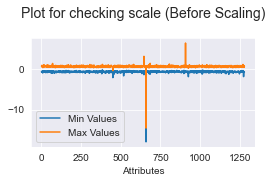

Train : Transforming Data (Scaling) Completed


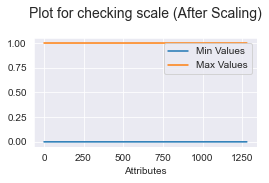

Test : Dropped duplicates:  0
Test : Data Cleaning Completed


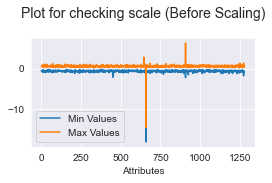

Test : Transforming Data (Scaling) Completed


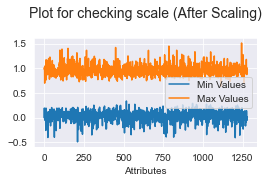

CPU times: total: 11.7 s
Wall time: 12.2 s


In [29]:
%%time
l2_pre_processing_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns)
    # Balancer(type='OS', features=feat_columns)
)

l2_pp_train = l2_pre_processing_pipe.fit_transform(model_l2.copy())
l2_pp_test = l2_pre_processing_pipe.transform(test_l2.copy())

Pre-processing done based on the finding or steps discovered from EDA.

#### Dealing with Class Imbalance

As discussed, we will test the models with both under-sampling and over-sampling.

Train : Resampling Completed


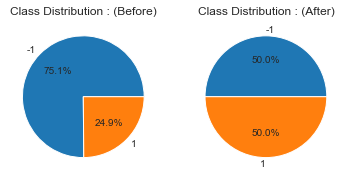

Total Observations :  1266
         Positives :  633   50.0 %
         Negatives :  633   50.0 %


In [30]:
l2_pp_train_us = Balancer(type='US', features=feat_columns).fit_transform(l2_pp_train.copy())
print_distribution(l2_pp_train_us)

Train : Resampling Completed


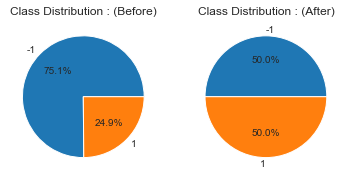

Total Observations :  3824
         Positives :  1912   50.0 %
         Negatives :  1912   50.0 %


In [31]:
l2_pp_train_os = Balancer(type='SMOTE', features=feat_columns).fit_transform(l2_pp_train.copy())
print_distribution(l2_pp_train_os)

## Baseline Model
***

So far, we have cleaned the data and prepared it for modelling. We have not performed any feature selections yet, but we can try out a basic model and check its performance, maybe a benchmark for further processing.

First, we will check for all three types of datasets using Logistic Regression and then with SVC. Then, we will consider whichever one has a better score (roc_auc_score) as the baseline model.

In [32]:
cols = feat_columns
l0 = LogisticRegression(random_state=42).fit(l2_pp_train[cols], l2_pp_train.Class)
l1 = LogisticRegression(random_state=42).fit(l2_pp_train_us[cols], l2_pp_train_us.Class)
l2 = LogisticRegression(random_state=42).fit(l2_pp_train_os[cols], l2_pp_train_os.Class)
print('Scores without FS: ',  str(type(l0)))
print('Default: ', roc_auc_score(l2_pp_test.Class, l0.predict(l2_pp_test[cols])))
print('UnderSampled: ', roc_auc_score(l2_pp_test.Class, l1.predict(l2_pp_test[cols])))
print('OverSampled: ', roc_auc_score(l2_pp_test.Class, l2.predict(l2_pp_test[cols])))

Scores without FS:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Default:  0.8711883566482972
UnderSampled:  0.8817860675427441
OverSampled:  0.9036597428288823


In [33]:
cols = feat_columns
l0 = SVC(random_state=42).fit(l2_pp_train[cols], l2_pp_train.Class)
l1 = SVC(random_state=42).fit(l2_pp_train_us[cols], l2_pp_train_us.Class)
l2 = SVC(random_state=42).fit(l2_pp_train_os[cols], l2_pp_train_os.Class)
print('Scores without FS: ',  str(type(l0)))
print('Default: ', roc_auc_score(l2_pp_test.Class, l0.predict(l2_pp_test[cols])))
print('UnderSampled: ', roc_auc_score(l2_pp_test.Class, l1.predict(l2_pp_test[cols])))
print('OverSampled: ', roc_auc_score(l2_pp_test.Class, l2.predict(l2_pp_test[cols])))

Scores without FS:  <class 'sklearn.svm._classes.SVC'>
Default:  0.8357496114172672
UnderSampled:  0.8704677123074749
OverSampled:  0.8792991380528473


Out of both models, LogisticRegression Classifier got the better roc_auc_score value for all the datasets. So, we will consider it as the baseline model. Next, we will try to apply

## Feature Engineering
***

Feature engineering is a critical step in building a predictive model, as the quality and relevance of the features can significantly impact the model’s performance. We will start with Mutual Information Gain’s importance scores to perform a primary feature selection. Next, we will determine a value or a small range of values as the number of features to select for a more advanced approaches like mRMR Algorithm (Maximum Relevance – Minimum Redundancy).

##### Mutual Information Gain

Number of features with ig_score > 0  882


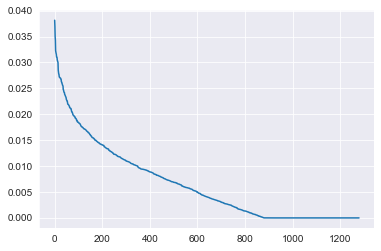

In [34]:
def check_mutual_information_gain(df):
    importances = mutual_info_classif(df[feat_columns], df.Class)
    return pd.Series(importances, feat_columns).sort_values(ascending=False)

mig_scores = check_mutual_information_gain(l2_pp_train)
plt.plot(mig_scores.values)
mig_features = mig_scores[mig_scores > 0]
print('Number of features with ig_score > 0 ', len(mig_features))

In [35]:
cols = mig_features.index
l0 = LogisticRegression(random_state=42).fit(l2_pp_train[cols], l2_pp_train.Class)
l1 = LogisticRegression(random_state=42).fit(l2_pp_train_us[cols], l2_pp_train_us.Class)
l2 = LogisticRegression(random_state=42).fit(l2_pp_train_os[cols], l2_pp_train_os.Class)
print('Scores based on Mutual Info Gain features: ')
print('Default: ', roc_auc_score(l2_pp_test.Class, l0.predict(l2_pp_test[cols])))
print('UnderSampled: ', roc_auc_score(l2_pp_test.Class, l1.predict(l2_pp_test[cols])))
print('OverSampled: ', roc_auc_score(l2_pp_test.Class, l2.predict(l2_pp_test[cols])))

Scores based on Mutual Info Gain features: 
Default:  0.8572135085488202
UnderSampled:  0.8642221280203476
OverSampled:  0.8730535537657201


##### mRMR - (Maximum Relevance – Minimum Redundancy)

mRMR, short for minimum Redundancy Maximum Relevance, is a feature selection algorithm used to select highly relevant features to the target variable while minimizing redundancy between the selected features.

In [36]:
# Using the number of importances that are > 0 from Mutual Information Gain
mrmr_features = mrmr_classif(l2_pp_train[feat_columns], l2_pp_train.Class, K=len(mig_features))

100%|██████████| 882/882 [02:37<00:00,  5.62it/s]


In [37]:
cols = mrmr_features
l0 = LogisticRegression(random_state=42).fit(l2_pp_train[cols], l2_pp_train.Class)
l1 = LogisticRegression(random_state=42).fit(l2_pp_train_us[cols], l2_pp_train_us.Class)
l2 = LogisticRegression(random_state=42).fit(l2_pp_train_os[cols], l2_pp_train_os.Class)
print('Scores mRMR FS: ', len(cols))
print('Default: ', roc_auc_score(l2_pp_test.Class, l0.predict(l2_pp_test[cols])))
print('UnderSampled: ', roc_auc_score(l2_pp_test.Class, l1.predict(l2_pp_test[cols])))
print('OverSampled: ', roc_auc_score(l2_pp_test.Class, l2.predict(l2_pp_test[cols])))

Scores mRMR FS:  882
Default:  0.856902642362583
UnderSampled:  0.8692948989684894
OverSampled:  0.8962413452027695


Let's try to use the combination of features from both MIFS and mRMR

In [38]:
combined_features = list(set([*mrmr_features, *(mig_features.index)]))
len(combined_features)

1115

In [39]:
cols = combined_features
l0 = LogisticRegression(random_state=42).fit(l2_pp_train[cols], l2_pp_train.Class)
l1 = LogisticRegression(random_state=42).fit(l2_pp_train_us[cols], l2_pp_train_us.Class)
l2 = LogisticRegression(random_state=42).fit(l2_pp_train_os[cols], l2_pp_train_os.Class)
print('Scores alternate mRMR FS: ')
print('Default: ', roc_auc_score(l2_pp_test.Class, l0.predict(l2_pp_test[cols])))
print('UnderSampled: ', roc_auc_score(l2_pp_test.Class, l1.predict(l2_pp_test[cols])))
print('OverSampled: ', roc_auc_score(l2_pp_test.Class, l2.predict(l2_pp_test[cols])))

Scores alternate mRMR FS: 
Default:  0.8601808675992652
UnderSampled:  0.8689840327822524
OverSampled:  0.8977250247279921


In [40]:
common_features = set(mrmr_features).intersection(set(mig_features.index))
len(common_features)

649

In [41]:
cols = common_features
l0 = LogisticRegression(random_state=42).fit(l2_pp_train[cols], l2_pp_train.Class)
l1 = LogisticRegression(random_state=42).fit(l2_pp_train_us[cols], l2_pp_train_us.Class)
l2 = LogisticRegression(random_state=42).fit(l2_pp_train_os[cols], l2_pp_train_os.Class)
print('Scores alternate mRMR FS: ')
print('Default: ', roc_auc_score(l2_pp_test.Class, l0.predict(l2_pp_test[cols])))
print('UnderSampled: ', roc_auc_score(l2_pp_test.Class, l1.predict(l2_pp_test[cols])))
print('OverSampled: ', roc_auc_score(l2_pp_test.Class, l2.predict(l2_pp_test[cols])))

Scores alternate mRMR FS: 
Default:  0.8554189628373604
UnderSampled:  0.8642221280203476
OverSampled:  0.8807828175780699


#### Checking with PCA

PCA (Principal Component Analysis) is a statistical technique used for dimensionality reduction. PCA can be used as a feature selection technique by selecting the top principal components that capture the most variation (variance) in the data.
While picking n components, have to keep 2 points in mind [5, 6], i.e.,
1. Picking Principal Components with a variance of at least 1.
2. Selected Components should be able to explain at least 80% or 90% of the total variance.


In [42]:
def plot_pca_check(pca_tuples):
    i = 1
    plt.figure(figsize=(30, 30))
    plt.subplots(2, len(pca_tuples), figsize=(20,10))
    for (title, pca) in pca_tuples:
        # print(len(pca.explained_variance_ratio_))

        plt.subplot(2, 3, i)
        plt.bar(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_, color='blue')
        plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, color='red')
        plt.axhline(y=1, color='green', linestyle='--')
        plt.title("\n".join(wrap('Figure - 1 : PCA Visualised ' + title, 50)), pad=20, fontsize=13, )
        plt.xlabel('Principal Components (Features)')
        plt.ylabel('Explained Variance')


        plt.subplot(2, 3, i+3)
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
        plt.axhline(y=90, color='green', linestyle='--')
        plt.axhline(y=95, color='yellow', linestyle='--')
        plt.title("\n".join(wrap('Figure - 2 : PCA Visualised : Cumulative Variance % vs Components ' + title, 50)), pad=20, fontsize=13, )
        plt.xlabel('# of Components')
        plt.ylabel('Cumulative % of explained variance')
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

        i += 1
    plt.show()

In [43]:
pca_0 = PCA().fit(l2_pp_train)
pca_us= PCA().fit(l2_pp_train_us)
pca_os = PCA().fit(l2_pp_train_os)

<Figure size 2160x2160 with 0 Axes>

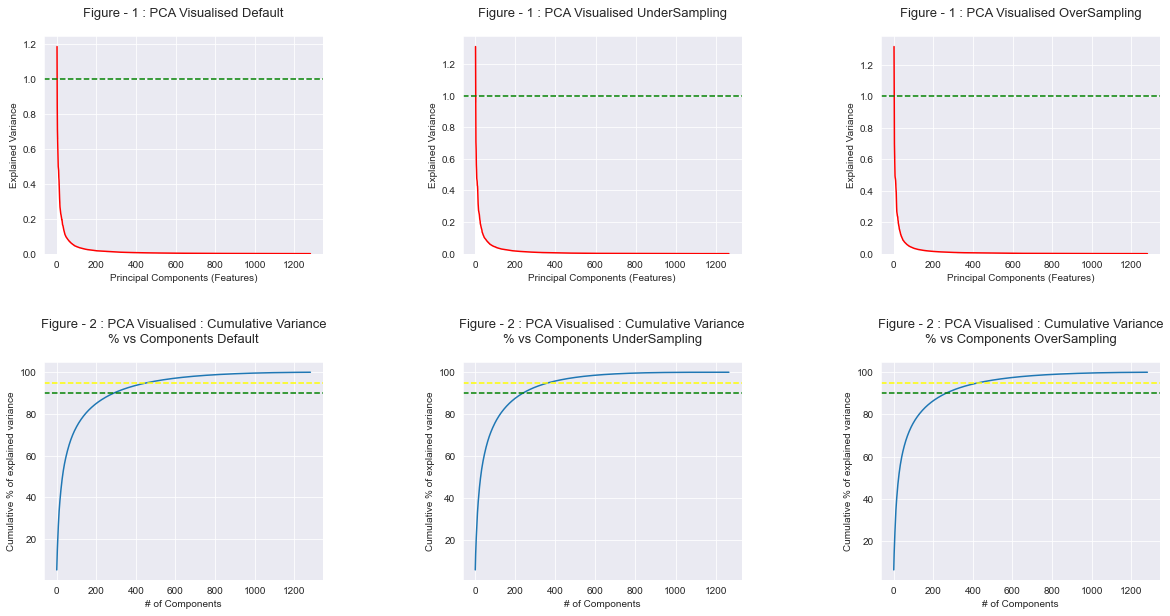

In [44]:
plot_pca_check([('Default', pca_0), ('UnderSampling', pca_us), ('OverSampling', pca_os)])

Let’s check with some values for n_components based on the graph, maybe 90 or 95% explained variance.

In [45]:
print('Scores with PCA using LogisticRegression: ')

# 95% -> 427
# 90% -> 263

pca = PCA(n_components=427) # 95%
pca_x = pca.fit_transform(l2_pp_train[feat_columns], l2_pp_train.Class)
pca_test_x = pca.transform(l2_pp_test[feat_columns])
clf = LogisticRegression(random_state=42)
clf.fit(pca_x, l2_pp_train.Class)
print('Default 427: ', roc_auc_score(l2_pp_test.Class, clf.predict(pca_test_x)))

pca = PCA(n_components=263) # 90%
pca_x = pca.fit_transform(l2_pp_train[feat_columns], l2_pp_train.Class)
pca_test_x = pca.transform(l2_pp_test[feat_columns])
clf = LogisticRegression(random_state=42)
clf.fit(pca_x, l2_pp_train.Class)
print('Default 263: ', roc_auc_score(l2_pp_test.Class, clf.predict(pca_test_x)))

Scores with PCA using LogisticRegression: 
Default 427:  0.8494842447364703
Default 263:  0.8491733785502332


After trying various feature selection techniques and algorithms, it is safe to say that our baseline model (without any Feature Selection) seems to perform better than other models with feature selection.

In [46]:
del l2_pp_train
del l2_pp_train_us
del l2_pp_train_os
del l2_pp_test,
del pca, pca_0, pca_x, pca_os, pca_us

In [47]:
def pca_features(n_components):
    feature_names = []
    for i in range(n_components):
        feature_names.append('Feature_' + str(i+1))
    return feature_names

##### PCA Transformer for pipeline

In [48]:
class PCA_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, components, features):
        self.components = components
        self.features = features
        self.mode = 'Train'
        self.pca = None

    def fit(self, df, y=None):
        self.mode = 'Train'
        print(self.mode, ': Fitting PCA')
        self.pca = PCA(n_components=self.components)
        self.pca.fit(df[self.features])
        return self

    def transform(self, df):
        pca_x = self.pca.transform(df[self.features].copy())
        pca_df = pd.DataFrame(data=pca_x, columns=pca_features(self.components))
        pca_df.index = df.index
        print(self.mode, ': PCA Feature Extraction Completed')
        self.mode = 'Test'
        pca_df['Class'] = df.Class.values
        return pca_df

### Setting up the Pipeline

In [49]:
l2_general_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    # Balancer(type='OS', features=feat_columns)
    # PCA_Transformer(components=200, features=feat_columns)
)

l2_us_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Balancer(type='US', features=feat_columns),
    # PCA_Transformer(components=200, features=feat_columns)
)

l2_os_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Balancer(type='SMOTE', features=feat_columns),
    # PCA_Transformer(components=200, features=feat_columns)
)

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


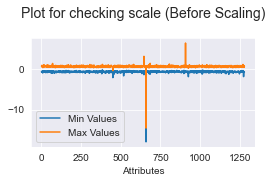

Train : Transforming Data (Scaling) Completed


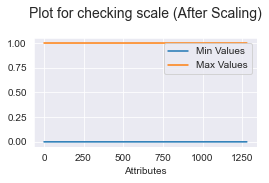

Test : Dropped duplicates:  0
Test : Data Cleaning Completed


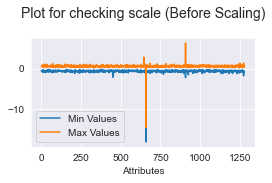

Test : Transforming Data (Scaling) Completed


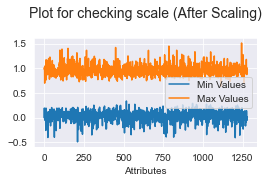

In [50]:
l2_train = l2_general_pipe.fit_transform(model_l2.copy())
l2_test = l2_general_pipe.transform(test_l2.copy())

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


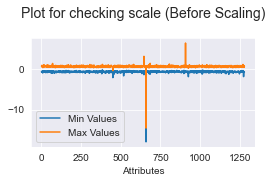

Train : Transforming Data (Scaling) Completed


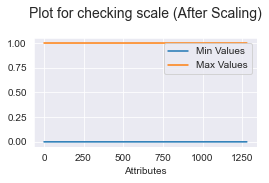

Train : Resampling Completed


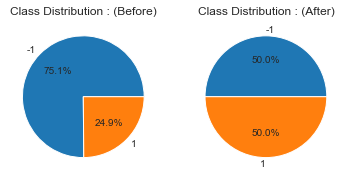

Test : Dropped duplicates:  0
Test : Data Cleaning Completed


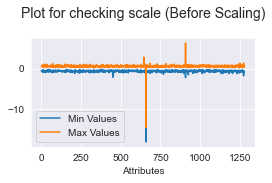

Test : Transforming Data (Scaling) Completed


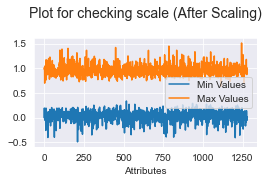

In [51]:
l2_us_train = l2_us_pipe.fit_transform(model_l2.copy())
l2_us_test = l2_us_pipe.transform(test_l2.copy())

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


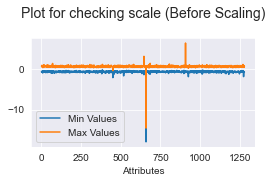

Train : Transforming Data (Scaling) Completed


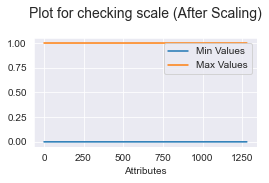

Train : Resampling Completed


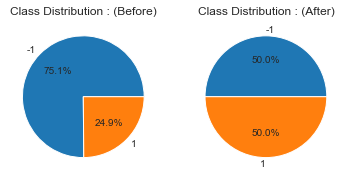

Test : Dropped duplicates:  0
Test : Data Cleaning Completed


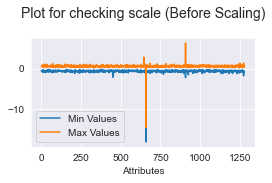

Test : Transforming Data (Scaling) Completed


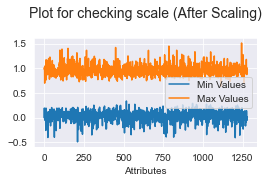

In [52]:
l2_os_train = l2_os_pipe.fit_transform(model_l2.copy())
l2_os_test = l2_os_pipe.transform(test_l2.copy())

## Building Model
***
Lets check the performance of the model with few classifiers and then fine tune parameters of the selected one.
-   LogisticRegression
-   SVM
-   RandomForrestClassifier
-   XGBoost

In [158]:
def test_model(clf, train, test, text='', mapper=False, extras=False):
    x_train = train.drop(columns=['Class'])
    y_train = train.Class

    # print(x_train.shape)
    # print(y_train)

    x_test = test.drop(columns=['Class'])
    y_test = test.Class

    if mapper:
        y_train = y_train.map({-1: 0, 1: 1})

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    if mapper:
        y_pred = pd.Series(y_pred).map({0: -1, 1: 1})

    print(text)
    print('AUC_ROC Score: ', roc_auc_score(y_test, y_pred))

    # calculate balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy:", bal_acc)

    # assume y_true and y_pred are the true and predicted class labels, respectively
    print(classification_report(y_test, y_pred))

In [54]:
lr = LogisticRegression(random_state=42)
print('For ', lr)
test_model(lr, l2_train, l2_test, 'Default :')
test_model(lr, l2_us_train, l2_us_test, 'UnderSampled :')
test_model(lr, l2_os_train, l2_os_test, 'OverSampled :')

For  LogisticRegression(random_state=42)
Default : AUC_ROC Score:  0.8711883566482972
UnderSampled : AUC_ROC Score:  0.8817860675427441
OverSampled : AUC_ROC Score:  0.9036597428288823


In [55]:
rf = RandomForestClassifier(random_state=42)
print('For ', rf)
test_model(rf, l2_train, l2_test, 'Default :')
test_model(rf, l2_us_train, l2_us_test, 'UnderSampled :')
test_model(rf, l2_os_train, l2_os_test, 'OverSampled :')

For  RandomForestClassifier(random_state=42)
Default : AUC_ROC Score:  0.6232584428430125
UnderSampled : AUC_ROC Score:  0.816362865621026
OverSampled : AUC_ROC Score:  0.7527624699731525


In [56]:
svc = SVC(random_state=42)
print('For ', svc)
test_model(svc, l2_train, l2_test, 'Default :')
test_model(svc, l2_us_train, l2_us_test, 'UnderSampled :')
test_model(svc, l2_os_train, l2_os_test, 'OverSampled :')

For  SVC(random_state=42)
Default : AUC_ROC Score:  0.8357496114172672
UnderSampled : AUC_ROC Score:  0.8704677123074749
OverSampled : AUC_ROC Score:  0.8792991380528473


In [57]:
xg = XGBClassifier()
print('For ', type(xg))
test_model(xg, l2_train, l2_test, 'Default :', mapper=True)
test_model(xg, l2_us_train, l2_us_test, 'UnderSampled :', mapper=True)
test_model(xg, l2_os_train, l2_os_test, 'OverSampled :', mapper=True)

For  <class 'xgboost.sklearn.XGBClassifier'>
Default : AUC_ROC Score:  0.7637699590221846
UnderSampled : AUC_ROC Score:  0.8199519570439451
OverSampled : AUC_ROC Score:  0.7914794404408647


LogisticRegression and SVM are top two model based on the roc_auc scores.

#### Hyperparameter Tuning

In [58]:
def hyperparam_tuning(model, params, train, mapper=False):
    grid = GridSearchCV(model, params, cv=5, scoring='roc_auc')

    x_train = train.drop(columns=['Class'])
    y_train = train.Class

    if mapper:
        y_train = y_train.map({-1: 0, 1: 1})

    grid.fit(x_train, y_train)

    print(type(model))
    print('- Best Hyper-parameters: ', grid.best_params_)
    # print('- Best AUC_ROC Score: ', grid.best_score_)
    return grid.best_estimator_

In [59]:
%%time
lg = LogisticRegression()
lg_params = {
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200, 300]
}
lr_best = hyperparam_tuning(lg, lg_params, l2_os_train, False)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
- Best Hyper-parameters:  {'max_iter': 300, 'solver': 'lbfgs'}
CPU times: total: 1min 56s
Wall time: 1min 42s


In [60]:
%%time
svc = SVC()
svc_params = {'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}
svc_best = hyperparam_tuning(svc, svc_params, l2_os_train, False)

<class 'sklearn.svm._classes.SVC'>
- Best Hyper-parameters:  {'gamma': 'scale', 'kernel': 'rbf'}
CPU times: total: 1min 59s
Wall time: 2min 8s


In [61]:
lr = lr_best
lr_cw = LogisticRegression(random_state=42, solver='lbfgs', max_iter=300, class_weight='balanced')
print('For Best', lr)
test_model(lr_cw, l2_train, l2_test, 'Default :')
test_model(lr, l2_us_train, l2_us_test, 'UnderSampled :')
test_model(lr, l2_os_train, l2_os_test, 'OverSampled :')

For Best LogisticRegression(max_iter=300)
Default : AUC_ROC Score:  0.9138052847251661
UnderSampled : AUC_ROC Score:  0.8832697470679667
OverSampled : AUC_ROC Score:  0.908421647590787


In [62]:
svc = svc_best
svc_cw = SVC(random_state=42, kernel='rbf', gamma='scale', class_weight='balanced')
print('For Best', svc_best)
test_model(svc_cw, l2_train, l2_test, 'Default :')
test_model(svc, l2_us_train, l2_us_test, 'UnderSampled :')
test_model(svc, l2_os_train, l2_os_test, 'OverSampled :')

For Best SVC()
Default : AUC_ROC Score:  0.8864773208986858
UnderSampled : AUC_ROC Score:  0.8704677123074749
OverSampled : AUC_ROC Score:  0.8792991380528473


#### Transformer for adding to pipeline

In [221]:
class Model(BaseEstimator, TransformerMixin):
    def __init__(self, model, features):
        self.features = features
        self.model = model
        self.sampler = None

    def fit(self, df, y=None):
        x = df[self.features]
        y = df.Class

        print('Train : Fitting Model with Training Data')
        self.model.fit(x, y)
        print('Train : Fitting Model with Training Data Completed')
        print('')
        print('Testing : ============================================')
        print('')
        return self

    def transform(self, df):
        return df

    def predict(self, df):
        print('')
        print('Predicting : =========================================')
        print('')

        x = df[self.features]

        y_pred = self.model.predict(x)

        y = df.Class

        auc_roc_score = roc_auc_score(y, y_pred)
        print('AUC-ROC score:', round(auc_roc_score, 2))

        return y_pred, df, self.model

Based on our results, the LogisticRegression model has better performance than others. As for the pipeline or process, the best baseline model is trained on over-sampled data, and the final best model is trained on unsampled data with balanced class weights.

In [169]:
l2_baseline_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Balancer(type='SMOTE', features=feat_columns),
    Model(
        model=LogisticRegression(random_state=42, max_iter=300),
        features=feat_columns
    )
)

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


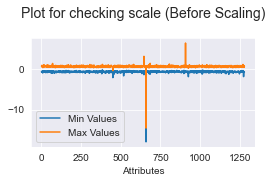

Train : Transforming Data (Scaling) Completed


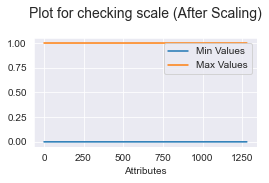

Train : Resampling Completed


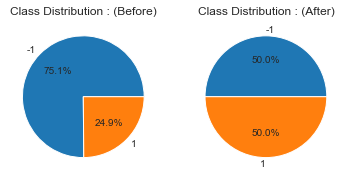

Train : Fitting Model with Training Data
Train : Fitting Model with Training Data Completed

Testing : ============================================

Test : Data Cleaning Completed


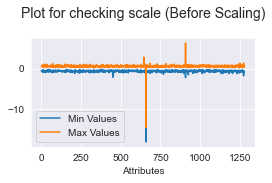

Test : Transforming Data (Scaling) Completed


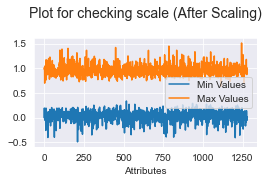


Predicting : =========================================

AUC-ROC score: 0.91
CPU times: total: 17.6 s
Wall time: 20.4 s


In [170]:
%%time
l2_baseline_train = l2_baseline_pipe.fit_transform(model_l2.copy())
_, l2_baseline_test, l2_baseline_model = l2_baseline_pipe.predict(test_l2.copy())

In [222]:
l2_best_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Model(
        model=LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
        features=feat_columns
    )
)

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


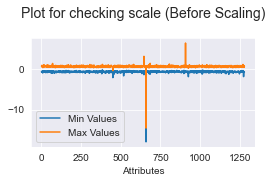

Train : Transforming Data (Scaling) Completed


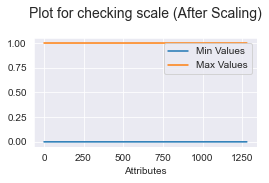

Train : Fitting Model with Training Data
Train : Fitting Model with Training Data Completed

Testing : ============================================

Test : Data Cleaning Completed


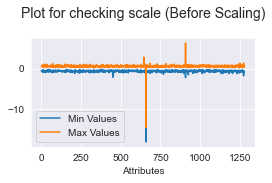

Test : Transforming Data (Scaling) Completed


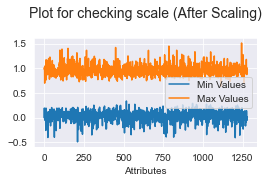


Predicting : =========================================

AUC-ROC score: 0.91
CPU times: total: 15.8 s
Wall time: 17.5 s


In [223]:
%%time
l2_best_train = l2_best_pipe.fit_transform(model_l2.copy())
_, l2_best_test, l2_best_model = l2_best_pipe.predict(test_l2.copy())

In [68]:
# Model 0 (baseline):
#     model   : l2_baseline_model : LogisticRegression(random_state=42, max_iter=300),
#     pipe    : l2_baseline_pipe
#     train   : l2_baseline_train
#     test    : l2_baseline_test
######################################
# Model 1 (best):
#     model   : l2_best_model : LogisticRegression(random_state=42, max_iter=300, class_weight='balanced')
#     pipe    : l2_best_pipe
#     train   : l2_best_train
#     test    : l2_best_test

## Level-3 Dataset
***
As planned, we will follow the same process as L2 while updating in light of new insights. L3 is relatively large compared to the L2 dataset (72663 records).

In [69]:
l3_data = pd.read_pickle('C:\Docs & Resources\Aston\Data Mining\Coursework\Data\df_training_level3.pkl')
print('Level 3 Dataset loaded, Shape : ', l3_data.shape)

Level 3 Dataset loaded, Shape :  (72663, 1294)


In [70]:
tmp_l3 = l3_data.copy()

##### A Quick EDA
Same as before, we will first check and remove nulls and duplicates.

In [71]:
print('Null Observations/Records : ', len(l3_data[l3_data[feat_columns].isna().all(axis=1)]))
print('Null Features : ', np.count_nonzero(l3_data[feat_columns].isna().all(axis=0) == True))
print('Duplicated Records : ', eda_check_duplicates(l3_data))

Null Observations/Records :  1912
Null Features :  0
Duplicates in the dataset :  0
Duplicated Records :  None


In [72]:
l3_data = pp_clean_old(l3_data)

Dropped Null and duplicate records :  1912


In [73]:
print('Null Observations/Records : ', len(l3_data[l3_data[feat_columns].isna().all(axis=1)]))
print('Duplicated Records : ', eda_check_duplicates(l3_data))

Null Observations/Records :  0
Duplicates in the dataset :  0
Duplicated Records :  None


After using the old approach (from L2), the nulls and duplicates seem to be cleared. But, If you look at the below records, you can see that all the features are the same but the Class value is 1 for one record and -1 for another. So, it is likely to be an error.

In [74]:
# Example of a duplicate record for (Only Features) i.e., same feature values, different labels
l3_data[[*feat_columns, *['Class']]].iloc[[9520, 5491]]

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279,Class
9520,-0.769371,-0.231707,-0.272149,-0.760779,-0.776141,-0.321674,-0.355737,0.216814,-0.399621,-0.364756,...,0.007444,-0.522056,-0.29854,1.165418,0.439176,-0.225306,-0.062885,-0.54384,0.12155,1
5491,-0.769371,-0.231707,-0.272149,-0.760779,-0.776141,-0.321674,-0.355737,0.216814,-0.399621,-0.364756,...,0.007444,-0.522056,-0.29854,1.165418,0.439176,-0.225306,-0.062885,-0.54384,0.12155,-1


In [75]:
print('Duplicated Records (Features): ', l3_data.duplicated(subset=feat_columns).sum())

Duplicated Records (Features):  731


After finding this, we have updated the existing transformers and previously defined functions so that the pipelines will stay robust to such issues.

In [76]:
def handle_duplicates_v2(df):
    # To remove data with duplicated features with different label
    # i.e,
    # consider 2 features and 1 target
    # a, b, 'win'
    # a, b, 'loss'
    # This is the type of records we'll find and remove
    # As we don't know which one is valid, we will retain first instance
    print('Duplicated Records (Features): ', df.duplicated(subset=feat_columns).sum())
    duplicates = df.duplicated(subset=feat_columns, keep='first')
    duplicate_indices = df.index[duplicates].tolist()
    df = df.drop(duplicate_indices)

    print('After Cleaning, duplicate Records: ', df.duplicated(subset=feat_columns).sum())

    df = df.reset_index(drop=True)
    return df

In [77]:
l3_data = handle_duplicates_v2(l3_data)

Duplicated Records (Features):  731
After Cleaning, duplicate Records:  0


In [78]:
print_distribution(l3_data)

Total Observations :  70020
         Positives :  37552   53.63 %
         Negatives :  32468   46.37 %


The classes are not perfectly balanced, but it seems to be a very slight imbalance. So, first, we will check for this without performing any over-sampling or under-sampling.

Since most of the findings are the same as L2, we will split the data into only 2 sets (Train and Test), perform pre-processing, and then prepare a baseline model.

Split folds: 
[8, 10, 7, 5, 4, 2, 9]
[1, 3, 6]


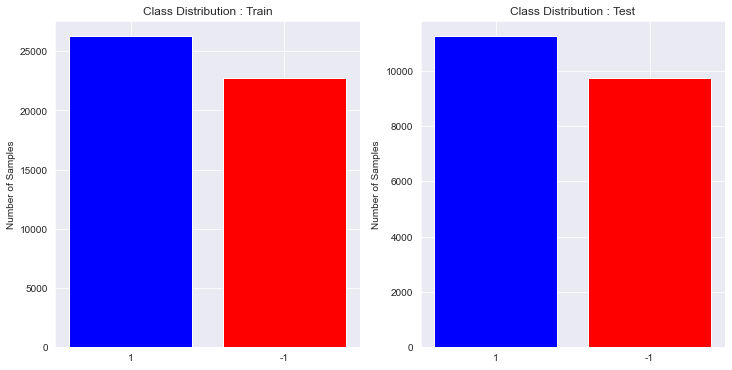

In [79]:
l3_kf = apply_kfolds(l3_data)
train_l3, test_l3 = get_split_data_by_fold(l3_kf, (7,3))
plot_distribution(dfs=[train_l3, test_l3], titles=['Train', 'Test'], plot='bar')

In [80]:
print_distribution(train_l3)

Total Observations :  49014
         Positives :  26285   53.63 %
         Negatives :  22729   46.37 %


In [81]:
l3_pp_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
)

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  3239  ( 0.07 %)
Train : Cleaning outliers ( 3239 ) Completed
Train : Fitting scaler


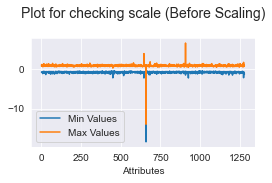

Train : Transforming Data (Scaling) Completed


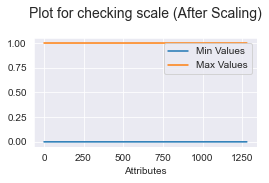

Test : Dropped duplicates:  0
Test : Data Cleaning Completed


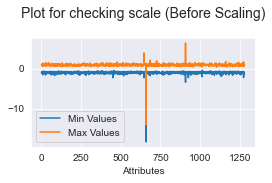

Test : Transforming Data (Scaling) Completed


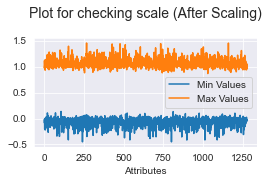

CPU times: total: 2min 27s
Wall time: 2min 39s


In [82]:
%%time
l3_pp_train = l3_pp_pipe.fit_transform(train_l3.copy())
l3_pp_test = l3_pp_pipe.transform(test_l3.copy())

In [173]:
l3_baseline_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Balancer(type='SMOTE', features=feat_columns),
    Model(
        model=LogisticRegression(random_state=42, max_iter=300),
        features=feat_columns
    )
)

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  3239  ( 0.07 %)
Train : Cleaning outliers ( 3239 ) Completed
Train : Fitting scaler


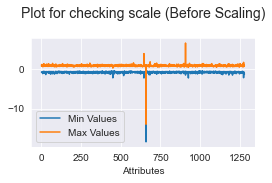

Train : Transforming Data (Scaling) Completed


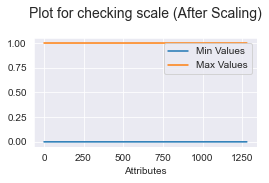

Train : Resampling Completed


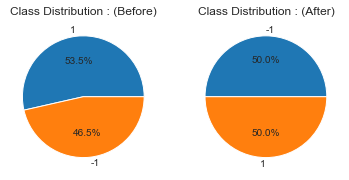

Train : Fitting Model with Training Data
Train : Fitting Model with Training Data Completed

Testing : ============================================

Test : Data Cleaning Completed


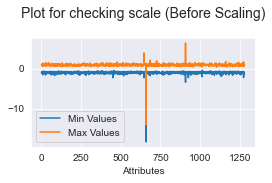

Test : Transforming Data (Scaling) Completed


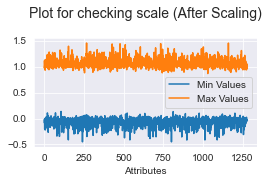


Predicting : =========================================

AUC-ROC score: 0.67
CPU times: total: 6min 44s
Wall time: 4min 15s


In [174]:
%%time
l3_train_os = l3_baseline_pipe.fit_transform(train_l3.copy())
_, _, l3_baseline_model = l3_baseline_pipe.predict(test_l3.copy())

##### Testing model performance of best L2 like

In [85]:
%%time
test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l3_pp_train,
    l3_pp_test,
    text='L2\'s best model for L3, AUC-ROC Score: '
)

L2's best model for L3, AUC-ROC Score:  AUC_ROC Score:  0.6691643827205953
CPU times: total: 59 s
Wall time: 24.3 s


<Figure size 2160x2160 with 0 Axes>

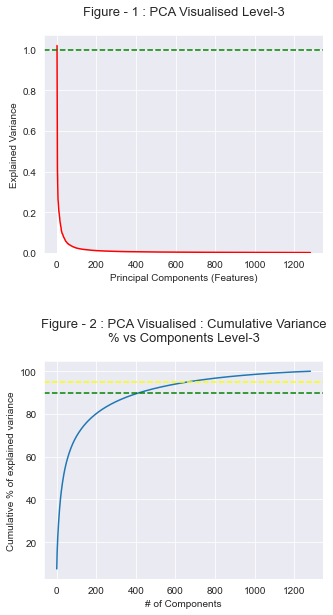

CPU times: total: 46.1 s
Wall time: 11 s


In [86]:
%%time
pca = PCA().fit(l3_pp_train)
plot_pca_check([('Level-3', pca)])

In [87]:
%%time
tmp_transformer = PCA_Transformer(components=400, features=feat_columns)
l3_pca_train = tmp_transformer.fit_transform(l3_pp_train.copy())
l3_pca_test = tmp_transformer.transform(l3_pp_test.copy())

test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l3_pca_train,
    l3_pca_test,
    text='Base LR with 400 pca :'
)

Train : Fitting PCA
Train : PCA Feature Extraction Completed
Test : PCA Feature Extraction Completed
Base LR with 400 pca : AUC_ROC Score:  0.649534372825245
CPU times: total: 1min 50s
Wall time: 12.9 s


In [88]:
%%time
tmp_transformer = PCA_Transformer(components=600, features=feat_columns)
l3_pca_train = tmp_transformer.fit_transform(l3_pp_train.copy())
l3_pca_test = tmp_transformer.transform(l3_pp_test.copy())

test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l3_pca_train,
    l3_pca_test,
    text='Base LR with 400 pca :'
)

Train : Fitting PCA
Train : PCA Feature Extraction Completed
Test : PCA Feature Extraction Completed
Base LR with 400 pca : AUC_ROC Score:  0.6535093544238266
CPU times: total: 2min 34s
Wall time: 18.4 s


In [102]:
mig_scores_l3 = check_mutual_information_gain(l3_pp_train)

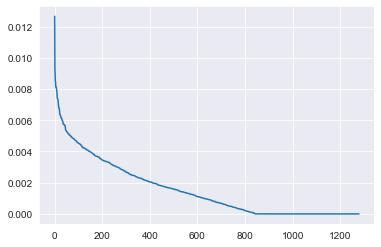

In [103]:
plt.plot(mig_scores_l3.values)

In [108]:
mig_scores_l3[mig_scores_l3 > 0].index.tolist()

Index(['feat_esm1b_134', 'feat_esm1b_1275', 'feat_esm1b_1164',
       'feat_esm1b_303', 'feat_esm1b_483', 'feat_esm1b_70', 'feat_esm1b_150',
       'feat_esm1b_705', 'feat_esm1b_580', 'feat_esm1b_1060',
       ...
       'feat_esm1b_658', 'feat_esm1b_193', 'feat_esm1b_441', 'feat_esm1b_9',
       'feat_esm1b_972', 'feat_esm1b_534', 'feat_esm1b_941', 'feat_esm1b_887',
       'feat_esm1b_1268', 'feat_esm1b_1017'],
      dtype='object', length=846)

In [122]:
%%time
tmp = mig_scores_l3[mig_scores_l3 > 0].index.tolist()
tmp.append('Class')
test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l3_pp_train[tmp],
    l3_pp_test[tmp],
    text='MIFS, AUC-ROC Score: '
)

MIFS, AUC-ROC Score:  AUC_ROC Score:  0.6547962985970759
CPU times: total: 1min 6s
Wall time: 22.1 s


In [98]:
sel_features = mrmr_classif(l3_pp_train[feat_columns], l3_pp_train.Class, 800)

100%|██████████| 800/800 [12:05<00:00,  1.10it/s]


In [130]:
tmp1 = sel_features.copy() + ['Class']
test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l3_pp_train[tmp],
    l3_pp_test[tmp],
    text='Base LR with 800 mrmr :'
)

Base LR with 800 mrmr : AUC_ROC Score:  0.6547962985970759


In [138]:
df1 = l2_data.copy()
df2 = l3_data.copy()
all_cols = [*feat_columns, *['Class']]

In [147]:
# check for common rows based on columns A and B
mask = df2['Info_PepID'].isin(df1['Info_PepID'])

In [150]:
l3_2_test = df2[~mask]

Test : Data Cleaning Completed


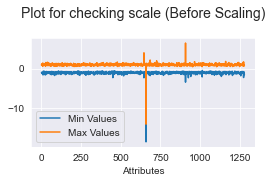

Test : Transforming Data (Scaling) Completed


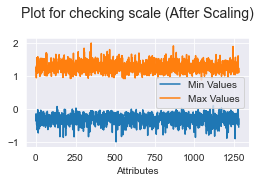


Predicting : =========================================

AUC-ROC score: 0.52
Balanced Accuracy: 0.5196238668462516


In [167]:
_ = l2_best_pipe.predict(l3_2_test)

In [ ]:
pca = PCA(n_components=427) # 95%
pca_x = pca.fit_transform(l2_pp_train[feat_columns], l2_pp_train.Class)
pca_test_x = pca.transform(l2_pp_test[feat_columns])
clf = LogisticRegression(random_state=42)
clf.fit(pca_x, l2_pp_train.Class)
print('Default 427: ', roc_auc_score(l2_pp_test.Class, clf.predict(pca_test_x)))

In [154]:
l2_pca_pipe = make_pipeline(
    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Balancer(type='SMOTE', features=feat_columns),
    PCA_Transformer(components=427, features=feat_columns),
    Model(
        model=LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
        features=pca_features(427)
    )
)

Training : ===========================================

Train : Dropped Nulls:  0
Train : Dropped duplicates:  0
Train : Data Cleaning Completed
Train : Potential outliers:  112  ( 0.04 %)
Train : Cleaning outliers ( 112 ) Completed
Train : Fitting scaler


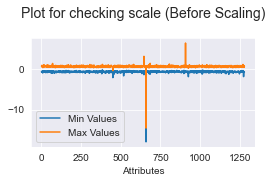

Train : Transforming Data (Scaling) Completed


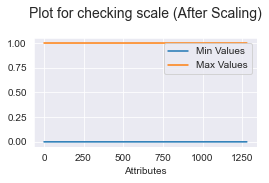

Train : Resampling Completed


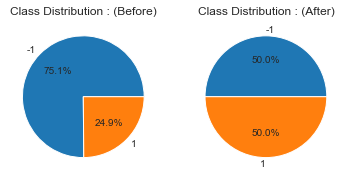

Train : Fitting PCA
Train : PCA Feature Extraction Completed
Train : Fitting Model with Training Data
Train : Fitting Model with Training Data Completed

Testing : ============================================

Test : Dropped duplicates:  0
Test : Data Cleaning Completed


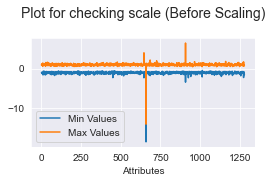

Test : Transforming Data (Scaling) Completed


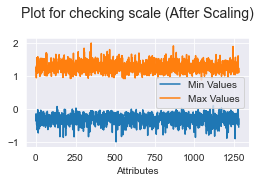

Test : PCA Feature Extraction Completed

Predicting : =========================================

AUC-ROC score: 0.52
CPU times: total: 3min 3s
Wall time: 2min 48s


In [155]:
%%time
_ = l2_pca_pipe.fit_transform(model_l2.copy())
_ = l2_pca_pipe.predict(l3_2_test.copy())

In [160]:
%%time
test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l2_best_train,
    l2_best_test,
    text='L2 Best Model '
)

L2 Best Model 
AUC_ROC Score:  0.9138052847251661
Balanced Accuracy: 0.9138052847251661
              precision    recall  f1-score   support

          -1       0.97      0.92      0.95       337
           1       0.79      0.90      0.84       105

    accuracy                           0.92       442
   macro avg       0.88      0.91      0.89       442
weighted avg       0.93      0.92      0.92       442

CPU times: total: 3.12 s
Wall time: 2.06 s


In [161]:
%%time
test_model(
    LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),
    l3_pp_train,
    l3_pp_test,
    text='Best model for L3'
)

Best model for L3
AUC_ROC Score:  0.6691643827205953
Balanced Accuracy: 0.6691643827205953
              precision    recall  f1-score   support

          -1       0.64      0.65      0.65      9739
           1       0.70      0.68      0.69     11267

    accuracy                           0.67     21006
   macro avg       0.67      0.67      0.67     21006
weighted avg       0.67      0.67      0.67     21006

CPU times: total: 1min 57s
Wall time: 31.8 s


In [90]:
# pipeline = make_pipeline(
#     DataCleaning(features=feat_columns),
#     Outliers(features=feat_columns),
#     Scaler(scaler=MinMaxScaler(), features=feat_columns),
#     Balancer(type='OS', features=feat_columns),
#     Model(model=RandomForestClassifier(random_state=17), features=feat_columns)
# )

## Final Model (Selected Model)
This is the best model obtain, i.e., from Level-2 dataset with following steps:

    DataCleaning(features=feat_columns),
    Outliers(features=feat_columns),
    Scaler(scaler=MinMaxScaler(), features=feat_columns),
    Model(model=LogisticRegression(random_state=42, max_iter=300, class_weight='balanced'),features=feat_columns)


Test : Data Cleaning Completed


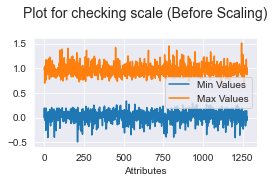

Test : Transforming Data (Scaling) Completed


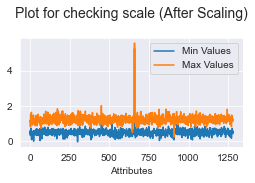


Predicting : =========================================

AUC-ROC score: 0.9


In [225]:
_, _, _ = l2_best_pipe.predict(l2_best_test)

## Holdout Dataset
***

In [226]:
holdout_data = pd.read_csv('../Data/df_holdout.csv')

In [227]:
holdout_data.shape

(2041, 1293)

Test : Data Cleaning Completed


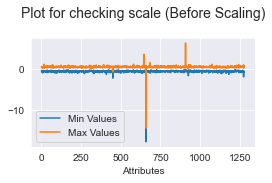

Test : Transforming Data (Scaling) Completed


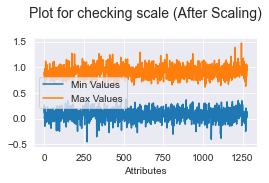

In [232]:
holdout_processed = l2_best_pipe.transform(holdout_data.copy())
y_pred = l2_best_model.predict(holdout_data[feat_columns])
predictons_df_1 = holdout_data[['Info_PepID', 'Info_pos']]
predictons_df_1['Prediction'] = y_pred

In [233]:
predictons_df_1.Prediction.value_counts()

 1    2015
-1      26
Name: Prediction, dtype: int64

In [229]:
# holdout_processed_2 = l2_baseline_pipe.transform(holdout_data.copy())
# y_pred_2 = l2_baseline_model.predict(holdout_processed_2[feat_columns])
# predictons_df_2 = holdout_data[['Info_PepID', 'Info_pos']]
# predictons_df_2['Prediction'] = y_pred_2
# # predictons_df_2.head()

In [230]:
# holdout_processed_3 = l3_baseline_pipe.transform(holdout_data.copy())
# y_pred_3 = l3_baseline_model.predict(holdout_processed_3[feat_columns])
# predictons_df_3 = holdout_data[['Info_PepID', 'Info_pos']]
# predictons_df_3['Prediction'] = y_pred_3
# # predictons_df_3.head()

In [235]:
predictons_df_1.to_csv('./Paleti_Bhageeradh_CS4850_predictions.csv', index=False)

## Conclusion
***

As discussed, we have tested multiple models with different approaches. Out of which, only two models have achieved high-performance scores. In order to deal with class imbalance, over-sampling with SMOTE and balancing class weights in the learning algorithm worked better than undersampling. The selected best model obtained has a 0.91 AUC ROC score built from the Level-2 dataset. However, even when the same process is followed to build the model from the level-3 dataset, the max performance achieved is 0.67. This could be because of the extra data added from the distant relatives of the Alphavirus.


## References
***

[1] J. Ashford, J. Reis-Cunha, I. Lobo, F. Lobo, and F. Campelo, “Organism-specific training improves performance of linear B-cell epitope prediction,” Bioinformatics, vol. 37, no. 24, pp. 4826–4834, Jul. 2021, doi: https://doi.org/10.1093/bioinformatics/btab536.

[2] J. Ashford and F. Campelo, “Estimated limits of organism-specific training for epitope prediction,” Nov. 2021, doi: https://doi.org/10.1101/2021.11.02.466801.

[3] F. Campelo, J. Reis-Cunha, J. Ashford, A. Ekárt, and F. P. Lobo, “Phylogeny-aware linear B-cell epitope predictor detects candidate targets for specific immune responses to Monkeypox virus,” Sep. 2022, doi: https://doi.org/10.1101/2022.09.08.507179.

[4] A. Rives et al., “Biological structure and function emerge from scaling unsupervised learning to 250 million protein sequences,” Proceedings of the National Academy of Sciences, vol. 118, no. 15, p. e2016239118, Apr. 2021, doi: https://doi.org/10.1073/pnas.2016239118.

[5] S. MANGALE, “Scree Plot,” Medium, Aug. 28, 2020. https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

[6] J. H. Steiger, “Principal Components Analysis,” Statpower.net, Feb. 16, 2015. http://www.statpower.net/Content/312/R%20Stuff/PCA.html